# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [80]:
# import libraries
import pyspark
from pyspark import SparkConf
#Import General Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

#Import possible Pyspark Library
from pyspark.ml import pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import LinearSVC, NaiveBayes,RandomForestClassifier, DecisionTreeClassifier, GBTClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.feature import CountVectorizer, IDF, StopWordsRemover, StringIndexer, Normalizer, RegexTokenizer, StandardScaler, VectorAssembler, PCA
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import avg, explode, concat, lit, min, max, split, udf, isnull, col, desc
from pyspark.sql import SparkSession, Window

In [2]:
# create a Spark session
spark = SparkSession \
.builder \
.appName("Sparkify") \
.config("spark.sql.catalogImplementation","hive") \
.getOrCreate()

# To display Spark session info


In [3]:
spark.sparkContext.getConf().getAll()

[('spark.driver.port', '44699'),
 ('spark.app.id', 'local-1628816544481'),
 ('spark.sql.catalogImplementation', 'hive'),
 ('spark.rdd.compress', 'True'),
 ('spark.app.name', 'Sparkify'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.driver.host', '7f0307a349cd')]

In [4]:
spark

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [5]:
user_log = spark.read.json("mini_sparkify_event_data.json")
user_log.createOrReplaceTempView("user_log_table")


In [6]:
spark.sql("DESC user_log_table").show()

+-------------+---------+-------+
|     col_name|data_type|comment|
+-------------+---------+-------+
|       artist|   string|   null|
|         auth|   string|   null|
|    firstName|   string|   null|
|       gender|   string|   null|
|itemInSession|   bigint|   null|
|     lastName|   string|   null|
|       length|   double|   null|
|        level|   string|   null|
|     location|   string|   null|
|       method|   string|   null|
|         page|   string|   null|
| registration|   bigint|   null|
|    sessionId|   bigint|   null|
|         song|   string|   null|
|       status|   bigint|   null|
|           ts|   bigint|   null|
|    userAgent|   string|   null|
|       userId|   string|   null|
+-------------+---------+-------+



In [7]:
spark.sql("SELECT * FROM user_log_table LIMIT 5")

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [8]:
spark.sql("SELECT * FROM user_log_table LIMIT 5").collect()

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

In [9]:
spark.sql("SELECT DISTINCT userID FROM user_log_table").collect()


[Row(userID='100010'),
 Row(userID='200002'),
 Row(userID='125'),
 Row(userID='51'),
 Row(userID='124'),
 Row(userID='7'),
 Row(userID='54'),
 Row(userID='15'),
 Row(userID='155'),
 Row(userID='132'),
 Row(userID='154'),
 Row(userID='100014'),
 Row(userID='101'),
 Row(userID='11'),
 Row(userID='138'),
 Row(userID='300017'),
 Row(userID='29'),
 Row(userID='69'),
 Row(userID='100021'),
 Row(userID='42'),
 Row(userID='112'),
 Row(userID='87'),
 Row(userID='73'),
 Row(userID='64'),
 Row(userID='200010'),
 Row(userID='3'),
 Row(userID='30'),
 Row(userID='113'),
 Row(userID='34'),
 Row(userID='133'),
 Row(userID='59'),
 Row(userID='146'),
 Row(userID='139'),
 Row(userID='8'),
 Row(userID='28'),
 Row(userID='22'),
 Row(userID='300018'),
 Row(userID='300012'),
 Row(userID='100022'),
 Row(userID='85'),
 Row(userID='52'),
 Row(userID='35'),
 Row(userID='16'),
 Row(userID='300008'),
 Row(userID='71'),
 Row(userID='98'),
 Row(userID='300013'),
 Row(userID='99'),
 Row(userID='47'),
 Row(userID='100

In [10]:
spark.sql("SELECT COUNT(*) AS totalNullEntries FROM user_log_table WHERE userId IS NULL OR sessionId IS NULL").show()

+----------------+
|totalNullEntries|
+----------------+
|               0|
+----------------+



In [11]:
spark.sql("SELECT * FROM user_log_table WHERE userId = ''").show()

+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+------+
|artist|      auth|firstName|gender|itemInSession|lastName|length|level|location|method| page|registration|sessionId|song|status|           ts|userAgent|userId|
+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+------+
|  null|Logged Out|     null|  null|          100|    null|  null| free|    null|   GET| Home|        null|        8|null|   200|1538355745000|     null|      |
|  null|Logged Out|     null|  null|          101|    null|  null| free|    null|   GET| Help|        null|        8|null|   200|1538355807000|     null|      |
|  null|Logged Out|     null|  null|          102|    null|  null| free|    null|   GET| Home|        null|        8|null|   200|1538355841000|     null|      |
|  null|Logged Out|     null|  nul

In [12]:
spark.sql("SELECT * FROM user_log_table WHERE sessionId = ''").show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+



In [13]:
user_log_valid = spark.sql("SELECT * FROM user_log_table WHERE userId != ''")
user_log_valid.createOrReplaceTempView("user_log_valid_table")
user_log_valid = spark.sql("SELECT * FROM user_log_valid_table ")




In [14]:
user_log_valid.show()

+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|           page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|      Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|       NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|    Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Bost

In [15]:
user_log_valid = user_log_valid.dropDuplicates().sort('userId')

In [16]:
spark.sql("SELECT DISTINCT page FROM user_log_valid_table ORDER BY page").show()

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|              Logout|
|            NextSong|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
|      Submit Upgrade|
|         Thumbs Down|
|           Thumbs Up|
|             Upgrade|
+--------------------+



In [17]:
spark.sql("SELECT DISTINCT page FROM user_log_valid_table ORDER BY page")


DataFrame[page: string]

In [18]:
user_log_valid = user_log_valid.toPandas()
user_log_valid.head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,The Jacksons,Logged In,Brycen,M,187,Bradley,211.19955,paid,"Laurel, MS",PUT,NextSong,1538159495000,595,Blame It On The Boogie,200,1539873446000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",10
1,None,Logged In,Brycen,M,256,Bradley,NaN,paid,"Laurel, MS",PUT,Thumbs Up,1538159495000,595,None,307,1539887833000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",10
2,Eminem,Logged In,Brycen,M,283,Bradley,250.82730,paid,"Laurel, MS",PUT,NextSong,1538159495000,595,Mockingbird,200,1539893026000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",10
3,Darwin Deez,Logged In,Brycen,M,312,Bradley,114.78159,paid,"Laurel, MS",PUT,NextSong,1538159495000,595,Lights On,200,1539898916000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",10
4,Alliance Ethnik,Logged In,Brycen,M,319,Bradley,195.94404,paid,"Laurel, MS",PUT,NextSong,1538159495000,595,SinceritÃÂ© Et Jalousie,200,1539901118000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",10


# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [19]:
df= user_log_valid
type(df)
df.head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,The Jacksons,Logged In,Brycen,M,187,Bradley,211.19955,paid,"Laurel, MS",PUT,NextSong,1538159495000,595,Blame It On The Boogie,200,1539873446000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",10
1,None,Logged In,Brycen,M,256,Bradley,NaN,paid,"Laurel, MS",PUT,Thumbs Up,1538159495000,595,None,307,1539887833000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",10
2,Eminem,Logged In,Brycen,M,283,Bradley,250.82730,paid,"Laurel, MS",PUT,NextSong,1538159495000,595,Mockingbird,200,1539893026000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",10
3,Darwin Deez,Logged In,Brycen,M,312,Bradley,114.78159,paid,"Laurel, MS",PUT,NextSong,1538159495000,595,Lights On,200,1539898916000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",10
4,Alliance Ethnik,Logged In,Brycen,M,319,Bradley,195.94404,paid,"Laurel, MS",PUT,NextSong,1538159495000,595,SinceritÃÂ© Et Jalousie,200,1539901118000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",10


In [20]:
df_spark=spark.createDataFrame(df)


In [21]:
# clearly represent registration and timestamp by creating new columns
new_ts = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%m-%d-%Y %H:%M:%S"))
df_spark = df_spark.withColumn('updated_registration', new_ts('registration'))
df_spark = df_spark.withColumn('updated_ts', new_ts('ts'))
df_spark.show()


+--------------------+---------+---------+------+-------------+--------+---------+-----+----------+------+---------+-------------+---------+--------------------+------+-------------+--------------------+------+--------------------+-------------------+
|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|  location|method|     page| registration|sessionId|                song|status|           ts|           userAgent|userId|updated_registration|         updated_ts|
+--------------------+---------+---------+------+-------------+--------+---------+-----+----------+------+---------+-------------+---------+--------------------+------+-------------+--------------------+------+--------------------+-------------------+
|        The Jacksons|Logged In|   Brycen|     M|          187| Bradley|211.19955| paid|Laurel, MS|   PUT| NextSong|1538159495000|      595|Blame It On The B...|   200|1539873446000|"Mozilla/5.0 (Mac...|    10| 09-28-2018 18:31:35|10-18-2018 14

In [22]:
# define a downgrade label
downgrade_value  = udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType())
df_spark = df_spark.withColumn("downgrade_value", downgrade_value("page"))



In [23]:
# define a downgrade label
dg_window = Window.partitionBy('UserId')
df_spark = df_spark.withColumn("user_downgrade", max('downgrade_value').over(dg_window))
df_spark.show()

+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+-----------+-------------+---------+--------------------+------+-------------+--------------------+------+--------------------+-------------------+---------------+--------------+
|              artist|     auth|firstName|gender|itemInSession| lastName|   length|level|            location|method|       page| registration|sessionId|                song|status|           ts|           userAgent|userId|updated_registration|         updated_ts|downgrade_value|user_downgrade|
+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+-----------+-------------+---------+--------------------+------+-------------+--------------------+------+--------------------+-------------------+---------------+--------------+
|                Bebe|Logged In| Darianna|     F|            1|Carpenter|225.77587| free|Bridgeport-Stamfo...|  

In [24]:
# define a churn label
churn_value = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())
df_spark = df_spark.withColumn("churn_value", churn_value("page"))
df_spark.show()

+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+-----------+-------------+---------+--------------------+------+-------------+--------------------+------+--------------------+-------------------+---------------+--------------+-----------+
|              artist|     auth|firstName|gender|itemInSession| lastName|   length|level|            location|method|       page| registration|sessionId|                song|status|           ts|           userAgent|userId|updated_registration|         updated_ts|downgrade_value|user_downgrade|churn_value|
+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+-----------+-------------+---------+--------------------+------+-------------+--------------------+------+--------------------+-------------------+---------------+--------------+-----------+
|                Bebe|Logged In| Darianna|     F|            1|Carpenter|225

In [25]:
# find all users who churned
churn_window = Window.partitionBy('UserId')
df_spark = df_spark.withColumn("user_churn", max('churn_value').over(churn_window))

In [26]:
# selecting few users to see
df_spark.select(['userId', 'firstName', 'level','updated_ts','user_churn', 'user_downgrade']).dropDuplicates(subset = ['userId']).show(10)

+------+---------+-----+-------------------+----------+--------------+
|userId|firstName|level|         updated_ts|user_churn|user_downgrade|
+------+---------+-----+-------------------+----------+--------------+
|100010| Darianna| free|11-09-2018 02:50:59|         0|             0|
|200002|  Dominic| free|10-16-2018 18:42:39|         0|             0|
|   125|    Mason| free|10-12-2018 04:35:17|         1|             0|
|   124|   Nicole| paid|10-02-2018 00:25:18|         0|             0|
|    51|    Ethan| paid|10-01-2018 14:49:15|         1|             0|
|     7|   Maddox| free|10-24-2018 02:48:34|         0|             0|
|    15|    Panav| paid|10-01-2018 11:54:38|         0|             0|
|    54|    Alexi| paid|10-01-2018 19:04:55|         1|             1|
|   155|   Camila| paid|11-09-2018 08:22:02|         0|             0|
|100014|  Rodrigo| paid|10-10-2018 16:19:53|         1|             0|
+------+---------+-----+-------------------+----------+--------------+
only s

In [27]:
# Display all unique pages
df_spark.select("page").dropDuplicates().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



In [28]:
# gender distribution between churn users and regular users
df_spark.drop_duplicates(['userId', 'gender']).groupby(['user_churn', 'gender']).count().sort("user_churn").show()

+----------+------+-----+
|user_churn|gender|count|
+----------+------+-----+
|         0|     M|   89|
|         0|     F|   84|
|         1|     F|   20|
|         1|     M|   32|
+----------+------+-----+



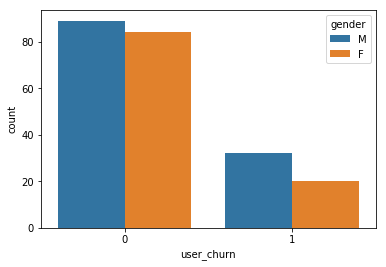

In [29]:
# Plotting a bar plot to show gender distribution between regular and churn users
df_ch_pd = df_spark.drop_duplicates(['userId', 'gender']).groupby(['user_churn', 'gender']).count().sort("user_churn").toPandas()
sns.barplot(x = 'user_churn', y = 'count', data = df_ch_pd, hue = 'gender')

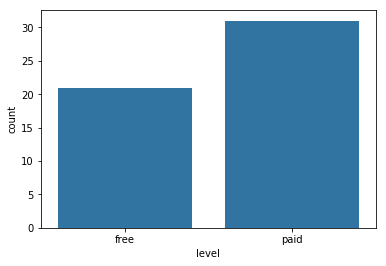

In [30]:
# Finding out which level customers churn more
level_df = df_spark.filter('page == "Cancellation Confirmation"').groupby('level').count().toPandas()
sns.barplot(data = level_df, x = 'level', y = 'count', color = sns.color_palette()[0])

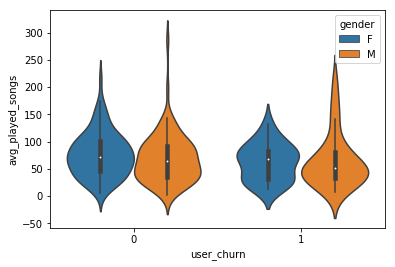

In [31]:
# Lets observe the gender distribution for number of songs played per session for churned and normal users
total_songs_df = df_spark.where('page == "NextSong"').groupby(['user_churn', 'userId', 'sessionId', 'gender']).count()\
    .groupby(['user_churn', 'userId', 'gender']).agg({'count': 'avg'})\
    .withColumnRenamed('avg(count)', 'avg_played_songs').toPandas()

ax = sns.violinplot('user_churn', y = 'avg_played_songs', hue = 'gender', data = total_songs_df)

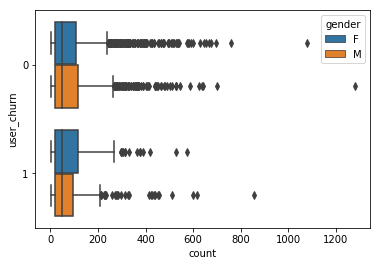

In [32]:
# Let's observe the gender distribution for total operations per session between normal and churned users
df_ops = df_spark.groupby("user_churn", "userId", "sessionId", 'gender').count().toPandas()
sns.boxplot(x = 'count', y = 'user_churn', orient = 'horizontal', data = df_ops, hue = 'gender')

In [33]:
spark.sql("SELECT COUNT(*) AS Number_of_Rows FROM user_log_table").collect()

[Row(Number_of_Rows=286500)]

In [34]:
spark.sql("SELECT COUNT(*) FROM user_log_valid_table WHERE level<>'free' AND level<>'paid'").show()

+--------+
|count(1)|
+--------+
|       0|
+--------+



In [35]:
spark.sql("SELECT sessionId, page, song FROM user_log_valid_table WHERE userId = '44' ORDER BY sessionId, itemInSession").show(100)

+---------+---------------+--------------------+
|sessionId|           page|                song|
+---------+---------------+--------------------+
|      183|           Help|                null|
|      183|       NextSong|Loving You (Dark ...|
|      183|       NextSong|        Panic Attack|
|      183|        Upgrade|                null|
|      183| Submit Upgrade|                null|
|      183|           Home|                null|
|      183|         Logout|                null|
|      183|           Home|                null|
|      183|       NextSong|             Phantom|
|      183|       NextSong|Bizarre Love Tria...|
|      183|       NextSong|         The Hollows|
|      183|       NextSong|      You're The One|
|      183|       NextSong|          Who's Real|
|      183|           Home|                null|
|      183|       NextSong| Frozen Orange Juice|
|      183|       NextSong|      Freedom Sounds|
|      183|       NextSong|             Silence|
|      183|       Ne

In [36]:
spark.sql("SELECT COUNT(*) FROM user_log_valid_table WHERE status =='307' OR status =='paid'").collect()

[Row(count(1)=23184)]

In [37]:
spark.sql("SELECT DISTINCT status, level FROM user_log_valid_table").show()

+------+-----+
|status|level|
+------+-----+
|   307| free|
|   200| paid|
|   404| paid|
|   307| paid|
|   200| free|
|   404| free|
+------+-----+



In [38]:
spark.sql('''SELECT COUNT(*) AS total, SUM (CASE WHEN diff = 0 THEN 1 ELSE 0 END) zero, SUM (CASE WHEN diff != 0 THEN 1 ELSE 0 END) nonzero
FROM (SELECT artist, song, MAX(length)-MIN(length) AS diff
FROM user_log_valid_table
WHERE song IS NOT NULL
GROUP BY artist, song)''').show()

+-----+-----+-------+
|total| zero|nonzero|
+-----+-----+-------+
|65416|64903|    513|
+-----+-----+-------+



In [39]:
# get max timestamp (this is to compute timeRegistered below)
max_ts = spark.sql("SELECT MAX(ts) FROM user_log_valid_table").collect()[0][0]
max_ts

1543799476000

In [40]:
pd.to_datetime(max_ts, unit='ms').to_pydatetime()

datetime.datetime(2018, 12, 3, 1, 11, 16)

In [41]:
spark.sql("SELECT DISTINCT COUNT(userId) FROM user_log_valid_table GROUP BY Level").show()

+-------------+
|count(userId)|
+-------------+
|       222433|
|        55721|
+-------------+



In [42]:
spark.sql("SELECT DISTINCT Level, COUNT(userId) FROM user_log_valid_table WHERE page = 'NextSong' GROUP BY Level").show()

+-----+-------------+
|Level|count(userId)|
+-----+-------------+
| free|        41991|
| paid|       186117|
+-----+-------------+



# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [43]:
# Feature 1 : Total number of  songs listened
feat_1 = df_spark.select('userId', 'song').groupBy('userId').count().withColumnRenamed('count', 'tot_songs')
feat_1.show()

+------+---------+
|userId|tot_songs|
+------+---------+
|100010|      381|
|200002|      474|
|   125|       11|
|   124|     4825|
|    51|     2464|
|     7|      201|
|    15|     2278|
|    54|     3437|
|   155|     1002|
|100014|      310|
|   132|     2304|
|   154|      118|
|   101|     2149|
|    11|      848|
|   138|     2469|
|300017|     4428|
|100021|      319|
|    29|     3603|
|    69|     1342|
|   112|      292|
+------+---------+
only showing top 20 rows



In [44]:
# Feature 2 : Number of thumbs up
feat_2 = df_spark.select('userId', 'page').where(df_spark.page == 'Thumbs Up').groupBy('userId').count().withColumnRenamed('count', 'tot_thumbs_up')
feat_2.show()

+------+-------------+
|userId|tot_thumbs_up|
+------+-------------+
|100010|           17|
|200002|           21|
|   124|          171|
|    51|          100|
|     7|            7|
|    15|           81|
|    54|          163|
|   155|           58|
|100014|           17|
|   132|           96|
|   154|           11|
|   101|           86|
|    11|           40|
|   138|           95|
|300017|          303|
|100021|           11|
|    29|          154|
|    69|           72|
|   112|            9|
|    42|          166|
+------+-------------+
only showing top 20 rows



In [45]:
# Feature 3 : Number of thumbs down
feat_3 = df_spark.select('userId', 'page').where(df_spark.page == 'Thumbs Down').groupBy('userId').count().withColumnRenamed('count', 'tot_thumbs_down')
feat_3.show()

+------+---------------+
|userId|tot_thumbs_down|
+------+---------------+
|100010|              5|
|200002|              6|
|   124|             41|
|    51|             21|
|     7|              1|
|    15|             14|
|    54|             29|
|   155|              3|
|100014|              3|
|   132|             17|
|   101|             16|
|    11|              9|
|   138|             24|
|300017|             28|
|100021|              5|
|    29|             22|
|    69|              9|
|   112|              3|
|    42|             25|
|    73|              7|
+------+---------------+
only showing top 20 rows



In [46]:
# Feature 4 : Total time since registration
feat_4 = df_spark.select('userId', 'registration', 'ts').withColumn('tot_lifetime', (df_spark.ts - df_spark.registration))\
    .groupBy('userId').agg({'tot_lifetime' : 'max'})\
    .withColumnRenamed('max(tot_lifetime)', 'tot_lifetime')\
    .select('userId', (col('tot_lifetime')/1000/3600/24).alias('tot_lifetime'))
feat_4.show()

+------+------------------+
|userId|      tot_lifetime|
+------+------------------+
|100010|  55.6436574074074|
|200002| 70.07462962962963|
|   125| 71.31688657407408|
|   124|131.55591435185184|
|    51|19.455844907407407|
|     7| 72.77818287037037|
|    15|56.513576388888886|
|    54|110.75168981481481|
|   155|23.556018518518517|
|100014| 85.08340277777778|
|   132|  66.8891087962963|
|   154|23.872037037037035|
|   101|53.965937499999995|
|    11|124.47825231481481|
|   138| 66.62668981481481|
|300017| 74.35851851851852|
|100021| 64.73886574074074|
|    29|60.104050925925925|
|    69| 71.42444444444445|
|   112| 87.46262731481481|
+------+------------------+
only showing top 20 rows



In [47]:
# Feature 5 : Total length of listening utilizing all services


feat_5 = df_spark.select("userId", 'length').groupBy('userId').sum().withColumnRenamed('sum(length)', 'tot_listen_time')
feat_5.show()

+------+---------------+
|userId|tot_listen_time|
+------+---------------+
|100010|            NaN|
|200002|            NaN|
|   125|            NaN|
|   124|            NaN|
|    51|            NaN|
|     7|            NaN|
|    15|            NaN|
|    54|            NaN|
|   155|            NaN|
|100014|            NaN|
|   132|            NaN|
|   154|            NaN|
|   101|            NaN|
|    11|            NaN|
|   138|            NaN|
|300017|            NaN|
|100021|            NaN|
|    29|            NaN|
|    69|            NaN|
|   112|            NaN|
+------+---------------+
only showing top 20 rows



In [48]:
df_spark.show()

+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+-----------+-------------+---------+--------------------+------+-------------+--------------------+------+--------------------+-------------------+---------------+--------------+-----------+----------+
|              artist|     auth|firstName|gender|itemInSession| lastName|   length|level|            location|method|       page| registration|sessionId|                song|status|           ts|           userAgent|userId|updated_registration|         updated_ts|downgrade_value|user_downgrade|churn_value|user_churn|
+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+-----------+-------------+---------+--------------------+------+-------------+--------------------+------+--------------------+-------------------+---------------+--------------+-----------+----------+
|                Bebe|Logged In| Darianna| 

In [49]:
# Feature 6 : Total number of friends
feat_6 = df_spark.select('userId', 'page').where(df_spark.page == 'Add Friend').groupBy('userId').count().withColumnRenamed('count', 'tot_friends')
feat_6.show()

+------+-----------+
|userId|tot_friends|
+------+-----------+
|100010|          4|
|200002|          4|
|   124|         74|
|    51|         28|
|     7|          1|
|    15|         31|
|    54|         33|
|   155|         11|
|100014|          6|
|   132|         41|
|   154|          3|
|   101|         29|
|    11|          6|
|   138|         41|
|300017|         63|
|100021|          7|
|    29|         47|
|    69|         12|
|   112|          7|
|    42|         52|
+------+-----------+
only showing top 20 rows



In [50]:
# Feature 7 : Gender of the user
feat_7 = df_spark.select('userId', 'gender').dropDuplicates().replace(['F', 'M'], ['0', '1'], 'gender').select('userId', col('gender').cast('int'))

feat_7.show()

+------+------+
|userId|gender|
+------+------+
|    44|     0|
|    46|     0|
|    41|     0|
|    72|     0|
|300023|     0|
|100010|     0|
|    39|     0|
|   116|     0|
|200001|     1|
|200020|     1|
|    35|     0|
|    40|     0|
|    75|     0|
|    94|     0|
|100008|     0|
|200015|     1|
|   100|     1|
|100006|     0|
|300005|     0|
|200016|     0|
+------+------+
only showing top 20 rows



In [51]:
# Feature 8 : Total number of songs listened per session
feat_8  = df_spark.where('page == "NextSong"').groupby(['userId', 'sessionId']).count().groupby('userId')\
          .agg({'count' : 'avg'}).withColumnRenamed('avg(count)', 'avg_played_songs')

feat_8.show()

+------+------------------+
|userId|  avg_played_songs|
+------+------------------+
|100010|39.285714285714285|
|200002|              64.5|
|   125|               8.0|
|    51|             211.1|
|   124|145.67857142857142|
|     7|21.428571428571427|
|    54| 81.17142857142858|
|    15|136.71428571428572|
|   155|136.66666666666666|
|100014|42.833333333333336|
|   132|             120.5|
|   154|              28.0|
|   101|             179.7|
|    11|           40.4375|
|300017|59.540983606557376|
|   138|             138.0|
|    29| 89.05882352941177|
|    69|             125.0|
|100021|              46.0|
|    42| 87.14634146341463|
+------+------------------+
only showing top 20 rows



In [52]:
# Feature 9 : Total number of artists the user has listened to
feat_9 = df_spark.filter(df_spark.page == "NextSong").select("userId", "artist").dropDuplicates().groupby("userId").count()\
         .withColumnRenamed("count", "tot_artist_played")
feat_9.show()

+------+-----------------+
|userId|tot_artist_played|
+------+-----------------+
|100010|              252|
|200002|              339|
|   125|                8|
|   124|             2232|
|    51|             1385|
|     7|              142|
|    15|             1302|
|    54|             1744|
|   155|              643|
|100014|              233|
|   132|             1299|
|   154|               78|
|   101|             1241|
|    11|              534|
|   138|             1332|
|300017|             2070|
|    29|             1804|
|    69|              865|
|100021|              207|
|    42|             2073|
+------+-----------------+
only showing top 20 rows



In [53]:
# setting the churn label for our model
target = df_spark.select('userId', col('user_churn').alias('target')).dropDuplicates()
target.show()


+------+------+
|userId|target|
+------+------+
|100010|     0|
|200002|     0|
|   125|     1|
|   124|     0|
|    51|     1|
|     7|     0|
|    15|     0|
|    54|     1|
|   155|     0|
|100014|     1|
|   132|     0|
|   154|     0|
|   101|     1|
|    11|     0|
|   138|     0|
|300017|     0|
|100021|     1|
|    29|     1|
|    69|     0|
|   112|     0|
+------+------+
only showing top 20 rows



In [54]:
# Combining all features with the target churn label

final_data = feat_1.join(feat_2, 'userId', 'inner').join(feat_3, 'userId', 'inner').join(feat_4, 'userId', 'inner')\
             .join(feat_6, 'userId', 'inner').join(feat_7, 'userId', 'inner')\
             .join(feat_8, 'userId', 'inner').join(feat_9, 'userId', 'inner').join(target, 'userId', 'inner').drop('userId')

final_data.show()

+---------+-------------+---------------+------------------+-----------+------+------------------+-----------------+------+
|tot_songs|tot_thumbs_up|tot_thumbs_down|      tot_lifetime|tot_friends|gender|  avg_played_songs|tot_artist_played|target|
+---------+-------------+---------------+------------------+-----------+------+------------------+-----------------+------+
|      381|           17|              5|  55.6436574074074|          4|     0|39.285714285714285|              252|     0|
|      474|           21|              6| 70.07462962962963|          4|     1|              64.5|              339|     0|
|     4825|          171|             41|131.55591435185184|         74|     0|145.67857142857142|             2232|     0|
|     2464|          100|             21|19.455844907407407|         28|     1|             211.1|             1385|     1|
|      201|            7|              1| 72.77818287037037|          1|     1|21.428571428571427|              142|     0|
|     22

In [55]:
fin_pd = final_data.toPandas()

In [56]:
# checking for any null values
fin_pd.isnull().sum()

tot_songs            0
tot_thumbs_up        0
tot_thumbs_down      0
tot_lifetime         0
tot_friends          0
gender               0
avg_played_songs     0
tot_artist_played    0
target               0
dtype: int64

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [57]:
ipcols = ['tot_songs', 'tot_thumbs_up', 'tot_thumbs_down', 'tot_lifetime', 'tot_friends', 'gender', 'avg_played_songs', 'tot_artist_played']
assmblr = VectorAssembler(inputCols = ipcols, outputCol = "VectFeatures")
final_data = assmblr.transform(final_data)
final_data.show()


+---------+-------------+---------------+------------------+-----------+------+------------------+-----------------+------+--------------------+
|tot_songs|tot_thumbs_up|tot_thumbs_down|      tot_lifetime|tot_friends|gender|  avg_played_songs|tot_artist_played|target|        VectFeatures|
+---------+-------------+---------------+------------------+-----------+------+------------------+-----------------+------+--------------------+
|      381|           17|              5|  55.6436574074074|          4|     0|39.285714285714285|              252|     0|[381.0,17.0,5.0,5...|
|      474|           21|              6| 70.07462962962963|          4|     1|              64.5|              339|     0|[474.0,21.0,6.0,7...|
|     4825|          171|             41|131.55591435185184|         74|     0|145.67857142857142|             2232|     0|[4825.0,171.0,41....|
|     2464|          100|             21|19.455844907407407|         28|     1|             211.1|             1385|     1|[2464.0

In [58]:
scaler = StandardScaler(inputCol = 'VectFeatures', outputCol = "newFeatures", withStd = True)
scaler_model = scaler.fit(final_data)
final_data = scaler_model.transform(final_data)

In [59]:
data = final_data.select(final_data.target.alias("label"), final_data.newFeatures.alias("features"))

In [60]:
#spark machine learning library 

    #test and train sets 80% training 20% test 
train, val = data.randomSplit([0.85, 0.15], seed = 42)
train = train.cache()
    #normalize 
    #logistic regression 
    #accuracy 
    #random forest  
    #acurracy 
    #gbm
    #accuracy 

In [61]:
train.show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    0|[0.28303716272111...|
|    0|[0.14931881812845...|
|    1|[1.83045556153494...|
|    0|[1.69227993878920...|
|    1|[2.55327750202744...|
|    0|[0.74436545156575...|
|    0|[1.71159481078592...|
|    1|[0.23029270457623...|
|    0|[0.62996197896981...|
|    1|[1.59644845849780...|
|    0|[1.83416995999585...|
|    0|[3.2894712769792,...|
|    0|[0.99694454690742...|
|    1|[0.23697862180586...|
|    1|[2.67659553092955...|
|    0|[0.21692087011696...|
|    0|[3.16243884961618...|
|    1|[0.33949601932689...|
|    1|[0.74510833125793...|
|    0|[0.23549286242150...|
+-----+--------------------+
only showing top 20 rows



In [62]:
val.show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    0|[0.35212497409397...|
|    0|[3.58439451477521...|
|    1|[0.18869144181407...|
|    0|[1.51993185020312...|
|    1|[0.71613602326286...|
|    0|[2.38761533067099...|
|    1|[0.16046201351118...|
|    0|[1.36838439299812...|
|    0|[1.90697216982963...|
|    0|[2.79397052229421...|
|    0|[0.72950785772212...|
|    0|[0.72579345926121...|
|    1|[0.46058540915246...|
|    1|[0.44572781530883...|
|    0|[1.78588278000406...|
|    1|[0.75030848910320...|
|    0|[1.57861934588545...|
|    1|[0.68047779803815...|
|    0|[1.39884246037755...|
|    0|[0.33875313963471...|
+-----+--------------------+
only showing top 20 rows



In [63]:
from pyspark.ml.classification import LogisticRegression

# Load training data
training = train

lr = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8)

# Fit the model
lrModel = lr.fit(training)

# Print the coefficients and intercept for logistic regression
print("Coefficients: " + str(lrModel.coefficients))
print("Intercept: " + str(lrModel.intercept))

# We can also use the multinomial family for binary classification
mlr = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8, family="multinomial")

# Fit the model
mlrModel = mlr.fit(training)

# Print the coefficients and intercepts for logistic regression with multinomial family
print("Multinomial coefficients: " + str(mlrModel.coefficientMatrix))
print("Multinomial intercepts: " + str(mlrModel.interceptVector))

Coefficients: (8,[],[])
Intercept: -1.3143208614948014
Multinomial coefficients: 2 X 8 CSRMatrix

Multinomial intercepts: [0.657160111656,-0.657160111656]


In [64]:
res_rf = mlrModel.transform(val)

In [65]:
evaluator = MulticlassClassificationEvaluator(predictionCol = "prediction")
print("The metrics for our Logistic Regerssion Classifier are as follows :")
print("The F-1 Score is {}".format(evaluator.evaluate(res_rf, {evaluator.metricName : "f1"})))
print("The accuracy is {}".format(evaluator.evaluate(res_rf, {evaluator.metricName : "accuracy"})))

The metrics for our Logistic Regerssion Classifier are as follows :
The F-1 Score is 0.5707915273132664
The accuracy is 0.6956521739130435


In [72]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Load and parse the data file, converting it to a DataFrame.
data = data

# Index labels, adding metadata to the label column.
# Fit on whole dataset to include all labels in index.
labelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel").fit(data)

# Automatically identify categorical features, and index them.
# Set maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer =\
    VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(data)

# Split the data into training and test sets (30% held out for testing)
(trainingData, testData) = data.randomSplit([0.7, 0.3])

# Train a RandomForest model.
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", numTrees=10)

# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)

# Chain indexers and forest in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf, labelConverter])

# Train model.  This also runs the indexers.
model = pipeline.fit(trainingData)

# Make predictions.
predictions = model.transform(testData)

# Select example rows to display.
predictions.select("predictedLabel", "label", "features").show(5)

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))

rfModel = model.stages[2]
print(rfModel)  # summary only

+--------------+-----+--------------------+
|predictedLabel|label|            features|
+--------------+-----+--------------------+
|             0|    0|[0.28303716272111...|
|             1|    1|[1.83045556153494...|
|             0|    0|[1.71159481078592...|
|             0|    1|[0.23029270457623...|
|             0|    0|[0.99694454690742...|
+--------------+-----+--------------------+
only showing top 5 rows

Test Error = 0.14
RandomForestClassificationModel (uid=RandomForestClassifier_1f77e01c194c) with 10 trees


In [73]:
evaluator = MulticlassClassificationEvaluator(predictionCol = "prediction")
print("The metrics for our random forest classifier are as follows :")
print("The F-1 Score is {}".format(evaluator.evaluate(predictions, {evaluator.metricName : "f1"})))
print("The accuracy is {}".format(evaluator.evaluate(predictions, {evaluator.metricName : "accuracy"})))

The metrics for our Logistic Regerssion Classifier are as follows :
The F-1 Score is 0.8432686414708888
The accuracy is 0.86


In [74]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Load and parse the data file, converting it to a DataFrame.
data = data

# Index labels, adding metadata to the label column.
# Fit on whole dataset to include all labels in index.
labelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel").fit(data)
# Automatically identify categorical features, and index them.
# Set maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer =\
    VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(data)

# Split the data into training and test sets (30% held out for testing)
(trainingData, testData) = data.randomSplit([0.7, 0.3])

# Train a GBT model.
gbt = GBTClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", maxIter=10)

# Chain indexers and GBT in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, gbt])

# Train model.  This also runs the indexers.
model = pipeline.fit(trainingData)

# Make predictions.
predictions = model.transform(testData)

# Select example rows to display.
predictions.select("prediction", "indexedLabel", "features").show(5)

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))

gbtModel = model.stages[2]
print(gbtModel)  # summary only

+----------+------------+--------------------+
|prediction|indexedLabel|            features|
+----------+------------+--------------------+
|       1.0|         0.0|[0.28303716272111...|
|       0.0|         0.0|[3.58439451477521...|
|       0.0|         1.0|[2.55327750202744...|
|       0.0|         0.0|[1.71159481078592...|
|       0.0|         1.0|[0.23029270457623...|
+----------+------------+--------------------+
only showing top 5 rows

Test Error = 0.153846
GBTClassificationModel (uid=GBTClassifier_bdce7d33c0ee) with 10 trees


In [75]:
evaluator = MulticlassClassificationEvaluator(predictionCol = "prediction")
print("The metrics for our GBT Classifier are as follows :")
print("The F-1 Score is {}".format(evaluator.evaluate(predictions, {evaluator.metricName : "f1"})))
print("The accuracy is {}".format(evaluator.evaluate(predictions, {evaluator.metricName : "accuracy"})))

The metrics for our Logistic Regerssion Classifier are as follows :
The F-1 Score is 0.8285714285714286
The accuracy is 0.8461538461538461


In [76]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Load the data stored in LIBSVM format as a DataFrame.
data = data

# Index labels, adding metadata to the label column.
# Fit on whole dataset to include all labels in index.
labelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel").fit(data)
# Automatically identify categorical features, and index them.
# We specify maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer =\
    VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(data)

# Split the data into training and test sets (30% held out for testing)
(trainingData, testData) = data.randomSplit([0.7, 0.3])

# Train a DecisionTree model.
dt = DecisionTreeClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures")

# Chain indexers and tree in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, dt])

# Train model.  This also runs the indexers.
model = pipeline.fit(trainingData)

# Make predictions.
predictions = model.transform(testData)

# Select example rows to display.
predictions.select("prediction", "indexedLabel", "features").show(5)

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g " % (1.0 - accuracy))

treeModel = model.stages[2]
# summary only
print(treeModel)

+----------+------------+--------------------+
|prediction|indexedLabel|            features|
+----------+------------+--------------------+
|       1.0|         1.0|[1.83045556153494...|
|       0.0|         1.0|[0.23029270457623...|
|       0.0|         0.0|[1.83416995999585...|
|       0.0|         1.0|[0.23697862180586...|
|       0.0|         0.0|[0.21692087011696...|
+----------+------------+--------------------+
only showing top 5 rows

Test Error = 0.288136 
DecisionTreeClassificationModel (uid=DecisionTreeClassifier_8d7bb67ffc37) of depth 5 with 25 nodes


In [77]:
evaluator = MulticlassClassificationEvaluator(predictionCol = "prediction")
print("The metrics for our DecisionTreeClassifier Classifier are as follows :")
print("The F-1 Score is {}".format(evaluator.evaluate(predictions, {evaluator.metricName : "f1"})))
print("The accuracy is {}".format(evaluator.evaluate(predictions, {evaluator.metricName : "accuracy"})))

The metrics for our Logistic Regerssion Classifier are as follows :
The F-1 Score is 0.6951188279408191
The accuracy is 0.711864406779661


In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder


rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", numTrees=10)
pipeline = Pipeline(stages=[rf])
paramGrid = ParamGridBuilder().addGrid(rf.numTrees, [10, 30]).build()

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=2) 

cvModel = crossval.fit(training_df)

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.